# Survival Analysis Tutorial Part 1

In [1]:
import pandas as pd
import numpy as np
import tqdm
import sklearn
from matplotlib import pyplot as plt

In [2]:
%pip install setuptools fastparquet lifelines "nbformat>=4.2.0" seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import utils
from dataset import generate_hazards

theoretical_hazards = generate_hazards()

Generating theoretical hazards...


In this tutorial we will introduce:

- What is **right-censored time-to-event data** and why naive regression models fail on such data,
- Unconditional survival analysis with the **Kaplan-Meier** estimator,
- Predictive survival analysis with **Cox Proportional Hazards**, **Survival Forests** and **Gradient Boosted Incidence**,
- How to assess the quality of survival estimators using the **Integrated Brier Score** and **C-index** metrics,
- Measuring the statistical association between input features and survival probabilities using **partial dependence plot** and **permutation feature importance**.

## 1. What is right-censored time-to-event data?

### 1.1. Censoring

Survival analysis is a time-to-event regression problem, with censored data. We call censored all individuals that didn't experience the event during the range of the observation window.

In our setting, we're mostly interested in right-censored data, meaning we that the event of interest did not occur before the end of the observation period (typically the time of collection of the dataset):

<figure>
<img src="assets/right_censoring_schema.png" style="width:70%">
<figcaption align = "center"> <i>Example lifetimes of individuals. We only observe up to time 10, but the blue individuals have not died yet (i.e. they are censored). Image credit: lifelines</i> </figcaption>
</figure>

Individuals can join the study at the same or different times, and the study may or may not be ended by the time of observation.

Survival analysis techniques have wide applications:

- In the **medical** landscape, events can consist in patients dying of cancer, or on the contrary recovering from some disease.
- In **predictive maintenance**, events can consist in machine failure.
- In **insurance**, we are interesting in modeling the time to next claim for a portfolio of insurance contracts.
- In **marketing**, we can consider user churning as events, or we could focus on users becoming premium (members that choose to pay a subscription after having used the free version of service for a while).
- **Economists** may be interested in modeling the time for unemployed people to find a new job.


As we will see, for all those applications, it is not possible to directly train a machine learning-based regression model on such a **right-censored** time-to-event target since we only have a lower bound on the true time to event for some data points. **Naively removing such points from the dataset would cause the model predictions to be biased**.

### 1.2. Our target `y`

For each individual $i\in[1, N]$, our survival analysis target $y_i$ is comprised of two elements:

- The event indicator $\delta_i\in\{0, 1\}$, where $0$ marks censoring and $1$ is indicative that the event of interest has actually happened before the end of the observation window.
- The censored time-to-event $d_i=min(t_{i}, c_i) > 0$, that is the minimum between the date of the experienced event $t_i$ and the censoring date $c_i$. In a real-world setting, we don't have direct access to $t_i$ when $\delta_i=0$. We can only record $d_i$.

Here is how we represent our target:

In [4]:
import pandas as pd
import numpy as np

truck_failure_events = pd.read_parquet("data/truck_failure_10k_any_event.parquet")
truck_failure_events

,event,duration
0,True,980.394661
1,True,1207.870100
2,False,125.000000
3,True,96.839004
4,True,88.077852
...,...,...
9995,True,0.435731
9996,True,356.591211
9997,True,847.951259
9998,True,25.551167


In this example, we study the accident of truck-driver pairs. Censored pairs (when event is 0 or False) haven't had a mechanical failure or an accident during the study.

### 1.3. Why is it a problem to train time-to-event regression models?

Without survival analysis, we have two naive options to deal with right-censored time to event data:
- We ignore censored data points from the dataset, only keep events that happened and perform naive regression on them.
- We consider that all censored events happen at the end of our observation window.

**Both approaches are wrong and lead to biased results.**

Let's compute the average and median time to event using either of those naive approaches on our truck failure dataset. We will compare them to the mean of the ground-truth event time $T$, that we would obtained with an infinite observation window. 

Note that we have access to the random variable $T$ because we generated this synthetic dataset. With real-world data, you only have access to $Y = \min(T, C)$, where $C$ is a random variable representing the censoring time.

In [5]:
naive_stats_1 = (
    truck_failure_events.query("event == True")["duration"]
    .apply(["mean", "median"])
)
print(
    f"Biased method 1 (removing censored points):\n"
    f"mean: {naive_stats_1['mean']:.1f} days, "
    f"median: {naive_stats_1['median']:.1f} days"
)

Biased method 1 (removing censored points):
mean: 597.8 days, median: 413.0 days


In [6]:
max_duration = truck_failure_events["duration"].max()
naive_stats_2 = (
    pd.Series(
        np.where(
            truck_failure_events["event"],
            truck_failure_events["duration"],
            max_duration,
        )
    )
    .apply(["mean", "median"])
)
print(
    f"Biased method 2 (censored events moved to the end of the window):\n"
    f"mean: {naive_stats_2['mean']:.1f} days, "
    f"median: {naive_stats_2['median']:.1f} days"
)

Biased method 2 (censored events moved to the end of the window):
mean: 1031.2 days, median: 909.6 days


In our case, the **data comes from a simple truck fleet simulator** and we have **access to the uncensored times** (we can wait as long as we want to extend the observation period as needed to have all trucks fail).

Let's have a look at the **true mean and median time-to-failure**:

In [7]:
truck_failure_events_uncensored = pd.read_parquet("data/truck_failure_10k_any_event_uncensored.parquet")

In [8]:
true_stats = truck_failure_events_uncensored["duration"].apply(["mean", "median"])
print(
    f"Ground truth (from the simulator):\n"
    f"mean: {true_stats['mean']:.2f} days, "
    f"median: {true_stats['median']:.2f} days"
)

Ground truth (from the simulator):
mean: 869.79 days, median: 735.45 days


We see that **neither of the naive ways to handle censoring gives a good estimate of the true mean or median time to event**.

If we have access to covariates $X$ (also known as input features in machine learning), a regression method would try to estimate $\mathbb{E}[T|X]$, where $X$ are our covariates, but we only have access to $Y = \min(T, C)$ where $T$ is the true time to failure and $C$ is the censoring duration. Fitting a **conditional regression model on right-censored data** would also require a special treatment because either of the **naive preprocessing** presented above would introduce a **significant bias in the predictions**.


Here is structured outline of the estimators we will introduce in this tutorial:


|                                          | Descriptive / unconditional: only `y`, no `X`        | Predictive / conditional: `y` given  `X`              |
|------------------------------------------|------------------------------------------------------|-------------------------------------------------------|
| Suvival Analysis (1 event type)          | Kaplan-Meier                                         | Cox PH, Survival Forests, Gradient Boosting Incidence |
| Competing Risks Analysis (k event types) | Aalen-Johansen                                       | Gradient Boosting Incidence                           |


Let's start with unconditional estimation of the any event survival curve.


## 2. Unconditional survival analysis with Kaplan-Meier

We now introduce the survival analysis approach to the problem of estimating the time-to-event from censored data. For now, we ignore any information from $X$ and focus on $y$ only.

Here our quantity of interest is the survival probability:

$$S(t)=P(T > t)$$ 

This represents the probability that an event doesn't occur at or before some given time $t$, i.e. that it happens at some time $T > t$.

The most commonly used method to estimate this function is the **Kaplan-Meier** estimator. It gives us an **unbiased estimate of the survival probability**. It can be computed as follows:

$$\hat{S}(t)=\prod_{i: t_i\leq t} (1 - \frac{d_i}{n_i})$$

Where:

- $t_i$ is the time of event for individual $i$ that experienced the event,
- $d_i$ is the number of individuals having experienced the event at $t_i$,
- $n_i$ are the remaining individuals at risk at $t_i$.

Note that **individuals that were censored before $t_i$ are no longer considered at risk at $t_i$**.

Contrary to machine learning regressors, this estimator is **unconditional**: it only extracts information from $y$ only, and cannot model information about each individual typically provided in a feature matrix $X$.

In a real-world application, we aim at estimating $\mathbb{E}[T]$ or $Q_{50\%}[T]$. The latter quantity represents the median survival duration i.e. the duration before 50% of our population at risk experiment the event.

We can also be interested in estimating the survival probability after some reference time $P(T > t_{ref})$, e.g. a random clinical trial estimating the capacity of a drug to improve the survival probability after 6 months.

In [9]:
from lifelines import KaplanMeierFitter


km = KaplanMeierFitter().fit(
    durations=truck_failure_events["duration"],
    event_observed=truck_failure_events["event"],
)

In [10]:
survival_probabilities = km.survival_function_.reset_index()
survival_probabilities

,timeline,KM_estimate
0,0.000000,1.000000
1,0.002191,0.999900
2,0.040457,0.999800
3,0.048228,0.999700
4,0.054303,0.999600
...,...,...
8289,1991.549943,0.074427
8290,1992.205806,0.074121
8291,1996.000000,0.074121
8292,1998.000000,0.074121


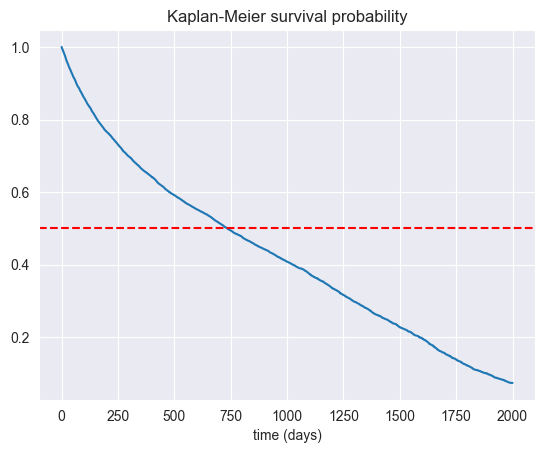

In [11]:
import seaborn as sns
sns.set_style("darkgrid")


fig, ax = plt.subplots()
ax.plot(
    survival_probabilities["timeline"],
    survival_probabilities["KM_estimate"],
)   
ax.axhline(0.50, linestyle="--", color="red", label="median")
ax.set(
    title="Kaplan-Meier survival probability",
    xlabel="time (days)",
);

In [12]:
km.median_survival_time_

734.2221714128043

We can read the median time to event directly from this curve: it is the time at the intersection of the estimate of the survival curve with the horizontal line for a 50% failure probility.

Since we have censored data, $\hat{S}(t)$ doesn't reach 0 within our observation window. We would need to extend the observation window to estimate the survival function beyond this limit. **Kaplan-Meier does not attempt the extrapolate beyond the last observed event**.

In [13]:
times = survival_probabilities["timeline"].values
km_estimate = survival_probabilities["KM_estimate"].values

<br>

**Exercice**

Based on `times` and `km_estimate`, estimate the median survival time.

*Hint: You can use [np.searchsorted](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html) on sorted probabilities in increasing order (reverse the natural order of the survival probabilities)*.

*Hint: Alternatively you can "inverse" the estimate of the survival curve using [scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) and take the value at probability 0.5.*

In [14]:
def compute_median_survival_time(times, km_estimate):
    """Get the closest time to a survival probability of 50%."""
    ### Your code here
    median_survival_time = 0
    ###
    return median_survival_time












compute_median_survival_time(times, km_estimate)

0

**Solution**

In [15]:
def compute_median_survival_time_with_searchsorted(times, km_estimate):
    """Get the closest time to a survival probability of 50%."""
    # Search sorted needs an array of ascending values:
    increasing_survival_probabilities = km_estimate[::-1]
    median_idx = np.searchsorted(increasing_survival_probabilities, 0.50)
    median_survival_time = times[-median_idx]
    return median_survival_time.round(decimals=1)


compute_median_survival_time_with_searchsorted(times, km_estimate)

734.2

In [16]:
from scipy.interpolate import interp1d


def compute_median_survival_time_with_interp1d(times, km_estimate):
    """Get the time to a survival proba of 50% via linear interpolation."""
    reverse_survival_func = interp1d(x=km_estimate, y=times, kind="linear")
    return reverse_survival_func([0.5])[0].round(decimals=1)


compute_median_survival_time_with_interp1d(times, km_estimate)

734.2

Here is the **true median survival time from the same data without any censoring** (generally not avaible in a real life setting).

In [17]:
truck_failure_events_uncensored["duration"].median().round(decimals=1)

735.4

This empirically confirms that the median survival time estimated by post-processing the KM estimate of the survival curve is a much better way to handle censored data than any the two naive approaches we considered in the beginning of this notebook.

### Mathematical break

We now introduce some quantities which are going to be at the core of many survival analysis models and Kaplan-Meier in particular.

The most important concept is the hazard rate $\lambda(t)$. This quantity represents the "speed of failure" or **the probability that an event occurs in the next $dt$, given that it hasn't occured yet**. This can be written as:

$$\begin{align}
\lambda(t) &=\lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt | P(T \geq t))}{dt} \\
&= \lim_{dt\rightarrow 0}\frac{P(t \leq T < t + dt)}{dtS(t)} \\
&= \frac{f(t)}{S(t)}
\end{align}
$$

where $f(t)$ represents the event density function, independently of wheter the event has happened before or not.

If we integrate $f(t)$, we get the cumulative incidence function (CIF) $F(t)=P(T < t)$, which is the complement of the survival function $S(t)$:

$$F(t) = 1 - S(t) = \int^t_0 f(u) du$$

Most of the time we do not attempt to evaluate $f(t)$. Instead we usually define the cumulative hazard function by integrating the hazard function:

$$\Lambda(t) = \int^t_0 \lambda(u) du$$

It can be shown that the survival function (and therefore the cumulative incidence function) can be computed as:

$$S(t) = e^{-\Lambda(t)}$$

$$F(t) = 1 - e^{-\Lambda(t)}$$

and if we have an estimate of $S(t)$ we can derive estimates of the cumulative hazard and instantenous hazard functions as:

$$\Lambda(t) = - log(S(t))$$

$$\lambda(t) = - \frac{S'(t)}{S(t)}$$

In practice, estimating the hazard function from a finite sample estimate of the survival curve can be quite challenging (from a numerical point of view). But the converse often works well.

Since our dataset was sampled from known hazard functions (one per truck), we can compute the theoretical survival curve by integrating over the time and taking the exponential of the negative. Let's give this a try:

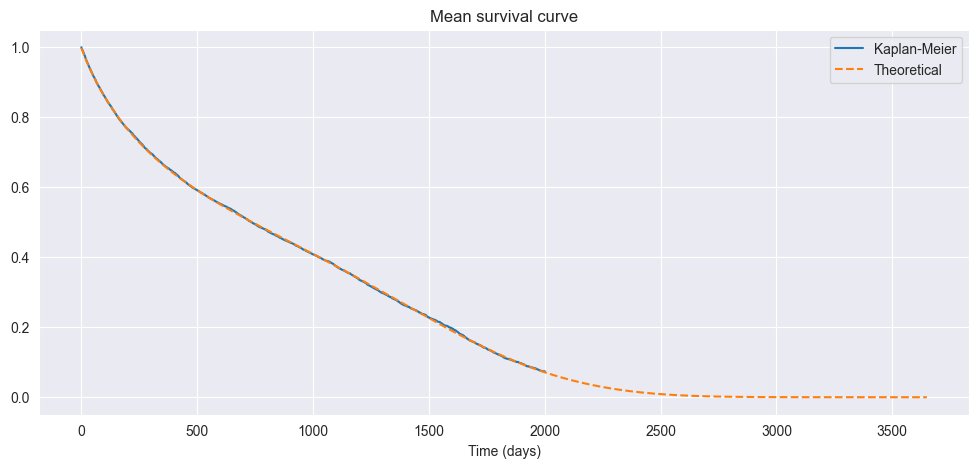

In [18]:
theoretical_cumulated_hazards = theoretical_hazards.cumsum(axis=-1)
mean_theoretical_survival_functions = np.exp(-theoretical_cumulated_hazards).mean(axis=0)
n_time_steps = mean_theoretical_survival_functions.shape[0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(times, km_estimate, label="Kaplan-Meier")
ax.plot(
    np.arange(n_time_steps), mean_theoretical_survival_functions,
    linestyle="--", label="Theoretical"
)
ax.set(title="Mean survival curve", xlabel="Time (days)")
ax.legend();

We observe that **Kaplan-Meier is an unbiased estimator of the survival curve** defined by the true hazard functions.

However we observe that then **KM estimate is no longer defined after the time of the last observed failure** (day 2000 in our case). In this dataset, all events are censored past that date: as a result **the KM survival curve does not reach zero** even when the true curve does. Therefore, it is **not possible to compute the mean survival time from the KM-estimate** alone. One would need to make some further assumptions to extrapolate it if necessary.

Furthermore, not all data generating process necessarily need to reach the 0.0 probability. For instance, survival analysis could be used to model a "time to next snow event" in different regions of the world. We can anticipate that it will never snow in some regions of the world in the foreseeable future.

### Kaplan-Meier on subgroups: stratification on columns of `X`

We can enrich our analysis by introducing covariates, that are statistically associated to the events and durations.

In [19]:
truck_failure_features = pd.read_parquet("data/truck_failure_10k_features.parquet")
truck_failure_features

,driver_skill,brand,truck_model,usage_rate
0,0.6,Cheapz,C3,0.80
1,0.8,Robusta,RA,0.50
2,0.7,Robusta,RB,0.55
3,0.6,Cheapz,C3,0.31
4,0.5,Cheapz,C1,0.75
...,...,...,...,...
9995,0.6,Robusta,RA,0.76
9996,0.5,Robusta,RB,0.75
9997,0.8,Cheapz,C2,0.64
9998,0.2,Cheapz,C1,0.63


In [20]:
truck_failure_features_and_events = pd.concat(
    [truck_failure_features, truck_failure_events], axis="columns"
)
truck_failure_features_and_events

,driver_skill,brand,truck_model,usage_rate,event,duration
0,0.6,Cheapz,C3,0.80,True,980.394661
1,0.8,Robusta,RA,0.50,True,1207.870100
2,0.7,Robusta,RB,0.55,False,125.000000
3,0.6,Cheapz,C3,0.31,True,96.839004
4,0.5,Cheapz,C1,0.75,True,88.077852
...,...,...,...,...,...,...
9995,0.6,Robusta,RA,0.76,True,0.435731
9996,0.5,Robusta,RB,0.75,True,356.591211
9997,0.8,Cheapz,C2,0.64,True,847.951259
9998,0.2,Cheapz,C1,0.63,True,25.551167


For exemple, let's use Kaplan Meier to get a sense of the impact of the **brand**, by stratifying on this variable.

***Exercice***

Plot the stratified Kaplan Meier of the brand, i.e. for each different brand:
1. Filter the dataset on this brand using pandas, for instance by using boolean masking with [.loc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) or using the [.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) method of the dataframe;
2. Estimate the survival curve with Kaplan-Meier on each subset. 
3. Plot the survival curve for each subset. *Hint: you can use [km.plot()](https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html#lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.plot)*

What are the limits of this method?

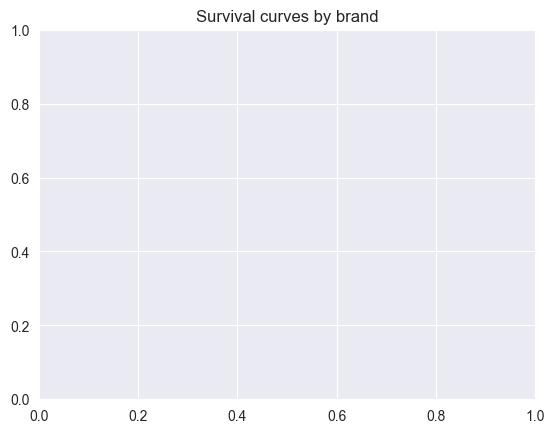

In [21]:
import matplotlib.pyplot as plt


def plot_km_curve_by_brand(df):
    brands = df["brand"].unique()
    fig_data = []
    for brand in brands:
        # TODO: replace the following by your code here:
        pass

    plt.title("Survival curves by brand")

    
plot_km_curve_by_brand(truck_failure_features_and_events)

**Solution**: click below to expand the cell:

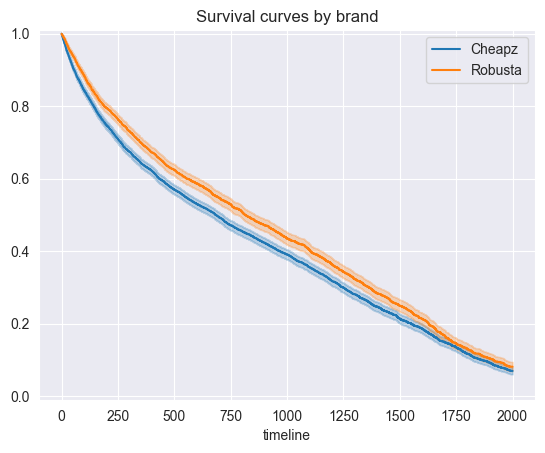

In [22]:
import matplotlib.pyplot as plt


def plot_km_curve_by_brand(df):
    brands = df["brand"].unique()
    fig_data = []
    for brand in brands:
        df_brand = df.loc[df["brand"] == brand]
        km = KaplanMeierFitter()
        km.fit(
            durations=df_brand["duration"],
            event_observed=df_brand["event"],
        )
        km.plot(label=brand)

    plt.legend()
    plt.ylim(-0.01, 1.01)
    plt.title("Survival curves by brand")
    
plot_km_curve_by_brand(truck_failure_features_and_events)

We can observe that drivers of "Cheapz" trucks seem to experiment a higher number of failures in the early days but then the cumulative number of failures for each group seem to become comparable.

The stratified KM method is nice to compare two groups but quickly becomes impracticable as the number of covariate groups grow. We need estimator that can handle covariates.

Let's now attempt to quantify how a survival curve estimated on a training set performs on a test set.

## 3. Survival model evaluation using the Integrated Brier Score (IBS) and the Concordance Index (C-index)

The Brier score and the C-index are measures that **assess the quality of a predicted survival curve** on a finite data sample.

- **The Brier score is a proper scoring rule**, meaning that an estimate of the survival curve has minimal Brier score if and only if it matches the true survival probabilities induced by the underlying data generating process. In that respect the **Brier score** assesses both the **calibration** and the **ranking power** of a survival probability estimator.

- On the other hand, the **C-index** only assesses the **ranking power**: it is invariant to a monotonic transform of the survival probabilities. It only focus on the ability of a predictive survival model to identify which individual is likely to fail first out of any pair of two individuals.



It is comprised between 0 and 1 (lower is better).
It answers the question "how close to the real probabilities are our estimates?".

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{BS}^c(t) = \frac{1}{n} \sum_{i=1}^n I(d_i \leq t \land \delta_i = 1)
        \frac{(0 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(d_i)} + I(d_i > t)
        \frac{(1 - \hat{S}(t | \mathbf{x}_i))^2}{\hat{G}(t)}$$
    
In the survival analysis context, the Brier Score can be seen as the Mean Squared Error (MSE) between our probability $\hat{S}(t)$ and our target label $\delta_i \in {0, 1}$, weighted by the inverse probability of censoring $\frac{1}{\hat{G}(t)}$. In practice we estimate $\hat{G}(t)$ using a variant of the Kaplan-Estimator with swapped event indicator.

- When no event or censoring has happened at $t$ yet, i.e. $I(d_i > t)$, we penalize a low probability of survival with $(1 - \hat{S}(t|\mathbf{x}_i))^2$.
- Conversely, when an individual has experienced an event before $t$, i.e. $I(d_i \leq t \land \delta_i = 1)$, we penalize a high probability of survival with $(0 - \hat{S}(t|\mathbf{x}_i))^2$.
    
<figure>
<img src="assets/BrierScore.svg" style="width:80%">
</figure>
    
</details>

Let's put this in practice. We first perform a train test split so as to fit the estimator on a traing sample and compute the performance metrics on a held-out test sample. We ensure that all the test data points lie well within the time range observed in the training set.

In [23]:
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X = truck_failure_features
y = truck_failure_events

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

Let's estimate the survival curve on the training set:

In [24]:
km = KaplanMeierFitter().fit(
    durations=y_train["duration"],
    event_observed=y_train["event"],
)
km.survival_function_

,KM_estimate
timeline,
0.000000,1.000000
0.054303,0.999600
0.173803,0.999200
0.194049,0.998800
0.375024,0.998399
...,...
1985.251885,0.073462
1990.000000,0.073462
1991.549943,0.072277


The `timeline` are ordered event (or censoring) times actually observed on the training set. To be able to compare that curve with curves computed on another time grid, we can use the [km.predict](https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html#lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.predict) method, that performs a step-wise constant interpolation.

In [25]:
def make_test_time_grid(y_train, n_steps=300):
    """Bound times to the range of duration."""
    # Some survival models can fail to predict near the boundary of the
    # range of durations observed on the training set.
    observed_duration = y_test.loc[y_test["event"] > 0]["duration"]
    
    # trim 1% of the span, 0.5% on each end:
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span
    stop = observed_duration.max() - 0.005 * span
    return np.linspace(start, stop, num=n_steps)


time_grid = make_test_time_grid(y_train)
time_grid.shape

(300,)

Kaplan-Meier is a constant predictor: it always estimates the mean survival curve for all individual in the (training) dataset: the estimated survival curve does not depend on features values of the `X_train` or `X_test` matrices.

To be able to compare the Kaplan-Meier estimator with conditional estimators who estimate indivudual survival curves for each row in `X_train` or `X_test` we treat KM as a constant predictor that always output the same survival curve as many times as there are rows in `X_test`:

In [26]:
km_curve = km.predict(time_grid)
y_pred_km_test = np.vstack([km_curve] * X_test.shape[0])
y_pred_km_test.shape

(7320, 300)

We can now compute one value of the Brier score for each time horizon in the test time grid using the values in `y_test` as ground truth targets using `hazardous.metrics.brier_score`:

In [27]:
from hazardous.metrics.brier_score import brier_score

_, km_brier_scores = brier_score(y_train, y_test, y_pred_km_test, time_grid)

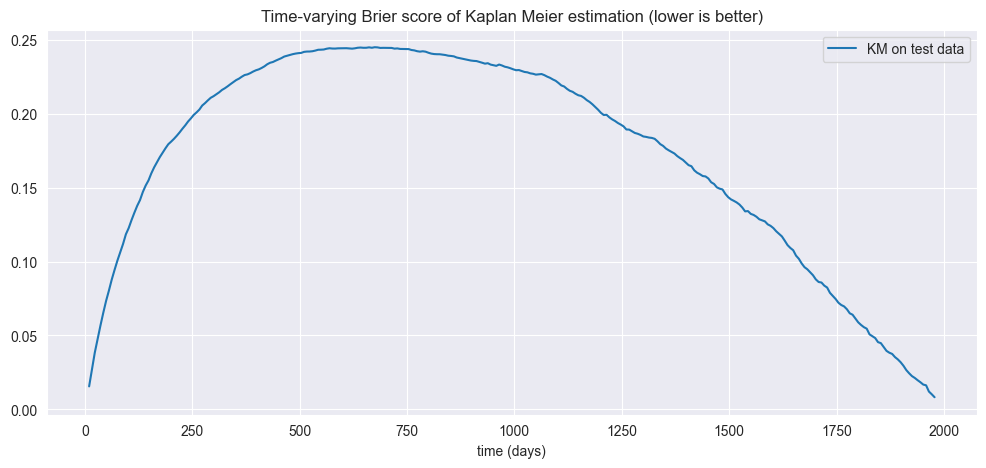

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_grid, km_brier_scores, label="KM on test data");
ax.set(
    title="Time-varying Brier score of Kaplan Meier estimation (lower is better)",
    xlabel="time (days)",
)
ax.legend();

We observed that the "prediction error" is largest for time horizons between 200 and 1500 days after the beginning of the observation period.


Additionnaly, we compute the Integrated Brier Score (IBS) which we will use to summarize the Brier score curve and compare the quality of different estimators of the survival curve on the same test set:
$$\mathrm{IBS} = \frac{1}{t_{max} - t_{min}}\int^{t_{max}}_{t_{min}} \mathrm{BS}(t) dt$$

In [29]:
from hazardous.metrics.brier_score import integrated_brier_score

km_ibs_test = integrated_brier_score(
    y_train,
    y_test,
    y_pred_km_test,
    time_grid,
)
print(f"IBS of Kaplan-Meier estimator on test set: {km_ibs_test:.3f}")

IBS of Kaplan-Meier estimator on test set: 0.174


Since the KM estimator always predicts the same constant survival curve for any samples in `X_train` or `X_test`, it's quite a limited model: it cannot rank individual by estimated median time to event for instance. Still, it's an interesting baseline because it's well calibrated among all the constant survival curve predictors.

For instance we could compare to a model that would predict a linear decrease of the survival probability over time and measure the IBS on the same test data. The KM-survival curve is hopefully better than such a dummy predictor:

In [30]:
linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = np.array([linear_survival_curve] * y_test.shape[0])

linear_survival_ibs_test = integrated_brier_score(
    y_train,
    y_test,
    constant_linear_survival_curves,
    time_grid,
)
print(f"IBS of linear survival estimator on test set: {linear_survival_ibs_test:.3f}")

IBS of linear survival estimator on test set: 0.185


Finally, let's also **introduce the concordance index (C-index)**. This metric evaluates the ranking (or discriminative) power of a model by comparing pairs of individuals having experienced the event. The C-index of a pair $(i, j)$ is maximized when individual $i$ has experienced the event before $j$ and the estimated risk of $i$ is higher than the one of $j$. 

This metric is also comprised between 0 and 1 (higher is better), 0.5 corresponds to a random prediction.

<details><summary>Mathematical formulation</summary>
    
$$\mathrm{C_{index}} = \frac{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1 \space \land \space \mu_i < \mu_j)}{\sum_{i,j} I(d_i < d_j \space \land \space \delta_i = 1)}$$

Let's introduce the cumulative hazards $\Lambda(t)$, which is the negative log of the survival function $S(t)$:

$$S(t) = \exp(-\Lambda(t)) = \exp(-\int^t_0 \lambda(u)du)$$
    
Therefore:
    
$$\Lambda(t) = -\log(S(t))$$

Finally, the risk $\mu_i$ is obtained by summing over the entire cumulative hazard:
    
$$\mu_i = \int^{t_{max}}_{t_{min}} \Lambda(t, x_i) dt = \int^{t_{max}}_{t_{min}} - \log (S(t, x_i)) dt$$
    
</details>

To compute the C-index of our Kaplan Meier estimates, we assign every individual with the same survival probabilities given by the Kaplan Meier.

In [31]:
def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

In [32]:
from lifelines.metrics import concordance_index


concordance_index(
    event_times=y_test["duration"],
    event_observed=y_test["event"],
    predicted_scores=survival_to_risk_estimate(y_pred_km_test),
)

0.5

This is equivalent to a random prediction. Indeed, as our Kaplan Meier is a unconditional estimator: it can't be used to rank individuals predictions as it predicts the same survival curve for any row in `X_test`.

Before moving forward, let's define a helper function that consolidates all the evaluation code together:

,Model,IBS,C-index
0,Constant linear,0.1854,0.5
1,Kaplan-Meier,0.1739,0.5


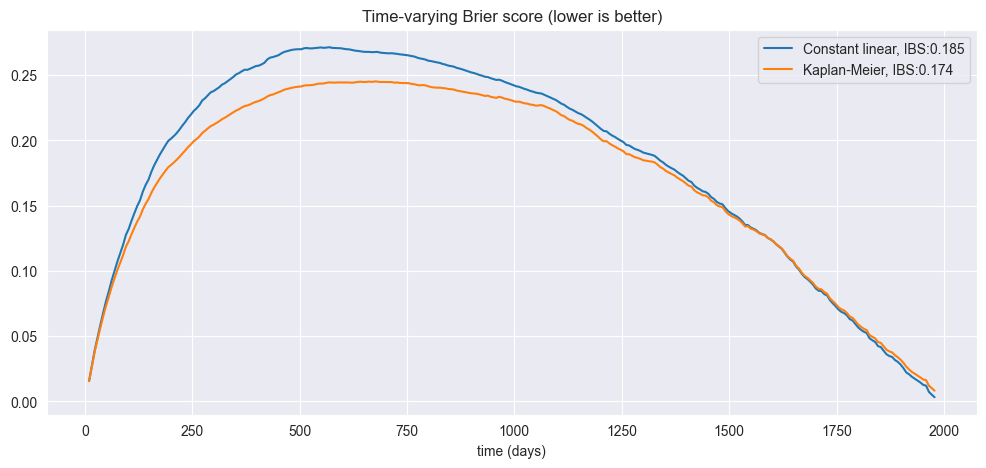

In [33]:
from utils import SurvivalAnalysisEvaluator


evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan-Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

Next, we'll study how to fit survival models that make predictions that depend on the covariates $X$.

## 4. Predictive survival analysis

### Cox Proportional Hazards

The Cox PH model is the most popular way of dealing with covariates $X$ in survival analysis. It computes a log-linear regression on the target $Y = \min(T, C)$, and consists in a baseline term $\lambda_0(t)$ and a covariate term with weights $\beta$.
$$\lambda(t, x_i) = \lambda_0(t) \exp(x_i^\top \beta)$$

Note that only the baseline depends on the time $t$, but we can extend Cox PH to time-dependent covariate $x_i(t)$ and time-dependent weigths $\beta(t)$. We won't cover these extensions in this tutorial.

This methods is called ***proportional*** hazards, since for two different covariate vectors $x_i$ and $x_j$, their ratio is:
$$\frac{\lambda(t, x_i)}{\lambda(t, x_j)} = \frac{\lambda_0(t) e^{x_i^\top \beta}}{\lambda_0(t) e^{x_j^\top \beta}}=\frac{e^{x_i^\top \beta}}{e^{x_j^\top \beta}}$$

This ratio is not dependent on time, and therefore the hazards are proportional.

Let's run it on our truck-driver dataset using the implementation of `lifelines`. This models requires preprocessing of the categorical features using One-Hot encoding. Let's use the `scikit-learn` column-transformer to combine the various components of the model as a pipeline:

In [34]:
X_train.head()

,driver_skill,brand,truck_model,usage_rate
8354,0.3,Cheapz,C1,0.43
5907,0.9,Robusta,RA,0.79
297,0.9,Robusta,RB,0.56
7561,0.4,Robusta,RB,0.82
3271,0.6,Cheapz,C2,0.58


In [35]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


simple_preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ["brand", "truck_model"]),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [36]:
simple_preprocessor.fit_transform(X_train)[:5]

array([[1.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.43],
       [0.  , 1.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.9 , 0.79],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.9 , 0.56],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.4 , 0.82],
       [1.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.6 , 0.58]])

In [37]:
from sklearn.pipeline import make_pipeline
from lifelines import CoxPHFitter

from utils import LifelinesWrapper

cox_estimator = LifelinesWrapper(CoxPHFitter(penalizer=1e-4))

cox_ph = make_pipeline(
    simple_preprocessor,
    cox_estimator,
)
cox_ph.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('lifelineswrapper',
                 LifelinesWrapper(estimator=<lifelines.CoxPHFitter: fitted with 2500 total observations, 736 right-censored observations>))])

Let's compute the predicted survival functions for each row of the test set `X_test` and plot the first 5 survival functions:

In [38]:
cox_ph_survival_probas = cox_ph.predict_survival_function(X_test, times=time_grid)
cox_ph_survival_probas.shape

(7320, 300)

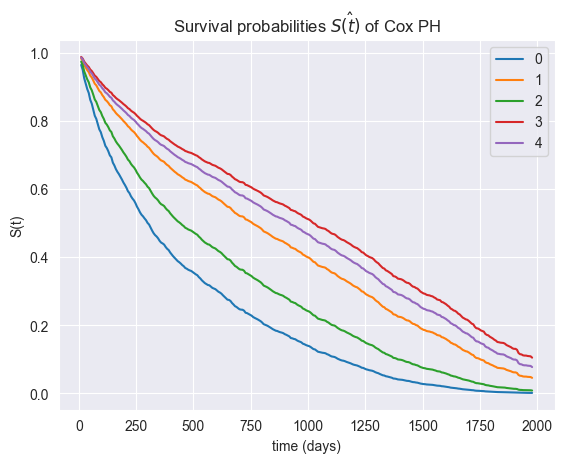

In [39]:
fig, ax = plt.subplots()
for idx, cox_ph_survival_proba in enumerate(cox_ph_survival_probas[:5]):
    ax.plot(time_grid, cox_ph_survival_proba, label=idx)
ax.set(
    title="Survival probabilities $\hat{S(t)}$ of Cox PH",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

Those estimated survival curves are predicted for the following test datapoints:

In [40]:
X_test.head(5).reset_index(drop=True)

,driver_skill,brand,truck_model,usage_rate
0,0.3,Cheapz,C2,0.62
1,0.5,Cheapz,C2,0.33
2,0.8,Robusta,RA,0.77
3,0.7,Cheapz,C3,0.83
4,0.7,Cheapz,C2,0.44


We see that predicted survival functions can vary significantly for different test samples.

There are two ways to read this plot:

First we could consider our **predictive survival analysis model as a probabilistic regressor**: if we want to **consider a specific probability of survival, say 50%**, we can mentally draw an horizontal line at 0.5, and see that:

- test data point `#0` has an estimated median survival time around 300 days,
- test data point `#1` has an estimated median survival time around 800 days,
- test data point `#2` has an estimated median survival time around 450 days...

Secondly we could also consider our **predictive survival analysis model as a probabilistic binary classifier**: if we **consider a specific time horizon, say 1000 days**, we can see that:

- test data point `#0` has less than a 20% chance to remain event-free at day 1000,
- test date point `#3` has around a 50% chance to remain event-free at day 1000...


Let's try to get some intuition about the features importance from the first 5 truck-driver pairs and their survival probabilities.

<br>

**Exercice**

We now want to find out which features have the strongest positive or negative impact on the predictions. 

Your goal is to plot the fitted coefficients $\beta$ with their names. 

To do so:
- Get the features and their coefficient, stored in the model as a pd.Series under `model.lifelines_model.params_`
- Sort the features by value and convert the series to a dataframe

*Hint*: You can access each step of a scikit-learn pipeline as simply as `pipeline[step_idx]`.

In [41]:
cox_ph  # the full pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('lifelineswrapper',
                 LifelinesWrapper(estimator=<lifelines.CoxPHFitter: fitted with 2500 total observations, 736 right-censored observations>))])

In [42]:
cox_ph[0]  # the first step of the pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['brand', 'truck_model'])],
                  verbose_feature_names_out=False)

In [43]:
cox_ph[1]  # the second step of the pipeline

<lifelines.CoxPHFitter: fitted with 2500 total observations, 736 right-censored observations>

In [44]:
### Your code here


coef = []
feature_names = []










###

**Solution**

In [45]:
features = (
    pd.DataFrame(
        dict(
            coef=cox_ph[-1].coef_,
            covariate=cox_ph[0].get_feature_names_out(),
        )
    ).sort_values("coef")
)
features

,coef,covariate
7,-1.727227,driver_skill
6,-0.579786,truck_model_RB
4,-0.524888,truck_model_C3
1,-0.034646,brand_Robusta
0,0.034646,brand_Cheapz
3,0.163793,truck_model_C2
2,0.431211,truck_model_C1
5,0.554779,truck_model_RA
8,1.439630,usage_rate


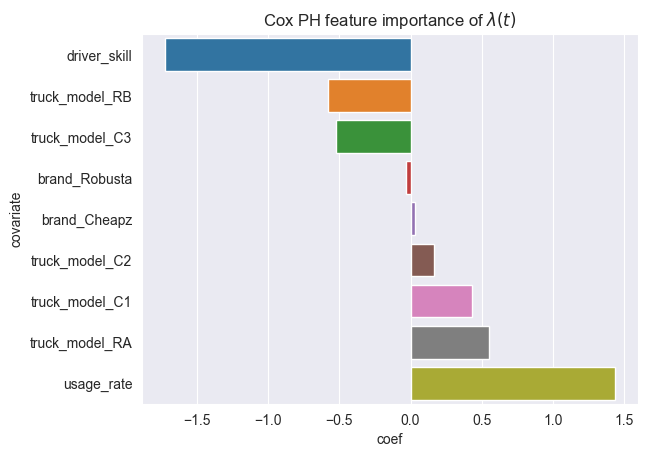

In [46]:
ax = sns.barplot(features, y="covariate", x="coef", orient="h")
ax.set_title("Cox PH feature importance of $\lambda(t)$");

Finally, we compute the Brier score for our model.

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902


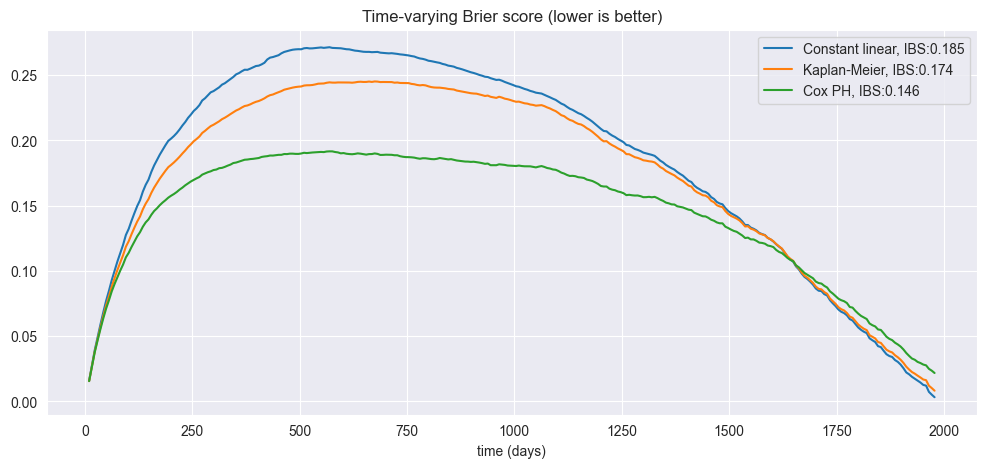

In [47]:
evaluator("Cox PH", cox_ph_survival_probas)

So, the Cox Proportional Hazard model fitted in a simple pipeline, with one-hot encoded categorical variables and raw numerical variables, seems significantly better than our unconditional baseline.

**Exercise**

Let's define a more expressive polynomial feature engineering pipeline for a Cox PH model that:

- encodes categorical variables using the `OneHotEncoder` as previously;
- transforms numerical features with [SplineTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) (using the default parameters);
- transforms the result of the encoded categorical variables and spline-transformed numerical variables. Let's use a degree 2 polynomial kernel approximation using the [Nystroem()](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html) method (e.g. Nystroem(kernel="poly", degree=2, n_components=300))

In [48]:
X.columns

Index(['driver_skill', 'brand', 'truck_model', 'usage_rate'], dtype='object')

In [49]:
from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem

# TODO: write your pipeline here.


# step 1: define a column transformer to:
# - one-hot encode categorical columns
# - spline-transform numerical features

# step 2: define a Nystroem approximate degree 2 polynomial feature expansion

# step 3: assemble everything in a pipeline with the CoxPHFitter
# model at the end.

# step 4: fit the pipeline on the training set.

# step 5: predict the survival functions (using `predict_survival_function`) on the test set, using `time_grid`.

# step 6: uncomment the following to evaluate your pipeline:

# evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1413,0.6966


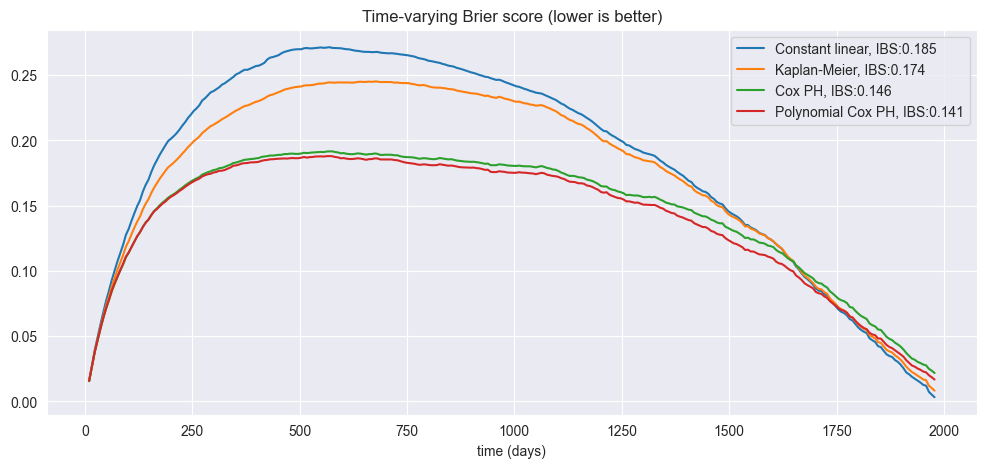

In [50]:
### Solution:

from sklearn.preprocessing import SplineTransformer
from sklearn.kernel_approximation import Nystroem


spline_preprocessor = make_column_transformer(
    (OneHotEncoder(), ["brand", "truck_model"]),
    (SplineTransformer(), ["driver_skill", "usage_rate"]),
    verbose_feature_names_out=False,
)

poly_cox_ph = make_pipeline(
    spline_preprocessor,
    Nystroem(kernel="poly", degree=2, n_components=300),
    LifelinesWrapper(CoxPHFitter(penalizer=1e-4)),
)

poly_cox_ph.fit(X_train, y_train)
poly_cox_ph_survival_probas = poly_cox_ph.predict_survival_function(X_test, times=time_grid)

evaluator("Polynomial Cox PH", poly_cox_ph_survival_probas)

### Gradient Boosting Incidence


We now introduce a novel survival estimator named Gradient Boosting Incidence. This estimator is based on the [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) of scikit-learn under the hood. It is named `Incidence` because it has the capability to estimate cause-specific Cumulative Incidence Functions in a competing risks setting by minimizing a cause specific IBS objective function.

To learn how Gradient Boosting Incidence works, see [our poster](https://www.dropbox.com/scl/fi/mi8ehqprymcpc91ex7tfl/euroscipy2023_hazardous.pdf?rlkey=wsh0bspdi1qqya8p2aliuq08a&dl=0).

In [51]:
from hazardous.gradient_boosting_incidence import GradientBoostingIncidence


gb_incidence = make_pipeline(
    simple_preprocessor,
    GradientBoostingIncidence(n_iter=100, max_leaf_nodes=5, learning_rate=0.1),
)
gb_incidence.fit(X_train, y_train)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 168.78it/s]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['brand', 'truck_model'])],
                                   verbose_feature_names_out=False)),
                ('gradientboostingincidence',
                 GradientBoostingIncidence(max_leaf_nodes=5, n_iter=100))])

100%|█████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 129.31it/s]


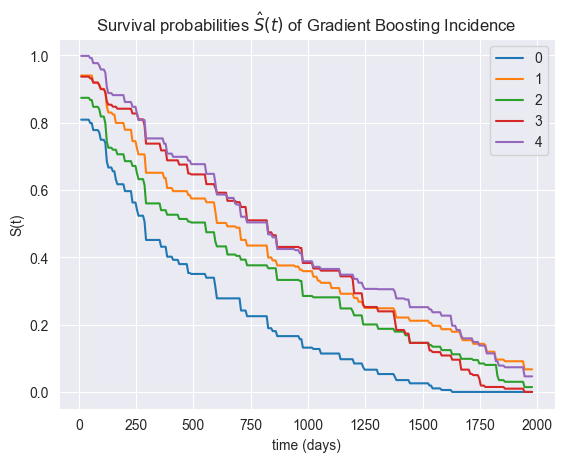

In [52]:
gb_incidence_survival_probas = gb_incidence.predict_survival_function(X_test, times=time_grid)

fig, ax = plt.subplots()
for idx, gb_incidence_survival_proba in enumerate(gb_incidence_survival_probas[:5]):
    ax.plot(time_grid, gb_incidence_survival_proba, label=idx)
ax.set(
    title="Survival probabilities $\hat{S}(t)$ of Gradient Boosting Incidence",
    xlabel="time (days)",
    ylabel="S(t)",
)
plt.legend();

Indeed we observe that the shapes of the curves can vary more than for the Cox-PH model which is more constrained. Let's see if this flexibility makes it a better predictive model on aggregate on the test set:

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1413,0.6966
4,Gradient Boosting Incidence,0.1407,0.6941


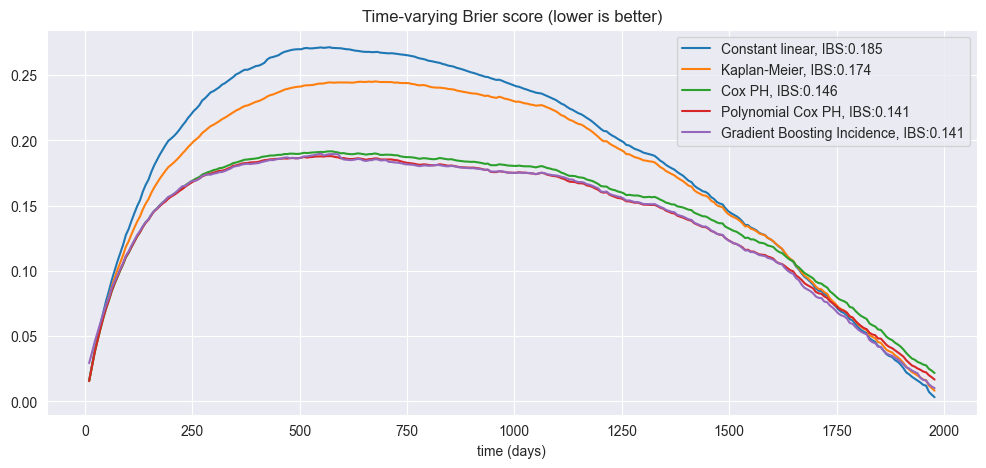

In [53]:
evaluator("Gradient Boosting Incidence", gb_incidence_survival_probas)

In [54]:
X_train.shape

(2500, 4)

The ranking power doesn't significantly improve upon the Cox PH model. However, Gradient Boosting Incidence model is often better than Cox PH but significantly faster to train and requires few feature engineering.

Let's try to improve the performance of the models that train fast on a larger dataset. As the `truck_failure_100k` dataset is a superset of the `truck_failure_10k` dataset, we reuse the sample test sampples to simplify model evaluation:

In [55]:
truck_failure_100k_any_event = pd.read_parquet("data/truck_failure_100k_any_event.parquet")
truck_failure_100k_features = pd.read_parquet("data/truck_failure_100k_features.parquet")

train_large_mask = np.full(shape=truck_failure_100k_any_event.shape[0], fill_value=True)
train_large_mask[idx_test] = False
X_train_large = truck_failure_100k_features[train_large_mask]
y_train_large = truck_failure_100k_any_event[train_large_mask]

large_model_evaluator = SurvivalAnalysisEvaluator(y_train_large, y_test, time_grid)

In [56]:
import gc

del truck_failure_100k_any_event, truck_failure_100k_features, train_large_mask
gc.collect()

15534

In [57]:
X_train_large.shape

(92680, 4)

**Warning**: fitting polynomial Cox PH on the larger training set takes several minutes on a modern laptop. Feel free to skip.

In [58]:
poly_cox_ph_large_survival_probas = None

In [59]:
%%time

#poly_cox_ph_large = make_pipeline(
#    spline_preprocessor,
#    Nystroem(kernel="poly", degree=2, n_components=300),
#    LifelinesWrapper(CoxPHFitter(penalizer=1e-4)),
#)
#poly_cox_ph_large.fit(X_train_large, y_train_large)
#poly_cox_ph_large_survival_probas = poly_cox_ph_large.predict_survival_function(X_test, times=time_grid)

#large_model_evaluator("Polynomial Cox PH (larger training set)", poly_cox_ph_large_survival_probas)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10 µs


Fitting `GradientBoostingIncidence` on the larger dataset should take a fraction of a minute on a modern laptop:

100%|█████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 110.38it/s]


CPU times: user 1min 45s, sys: 3.63 s, total: 1min 49s
Wall time: 15.8 s


,Model,IBS,C-index
0,Gradient Boosting Incidence (larger training set),0.1398,0.6954


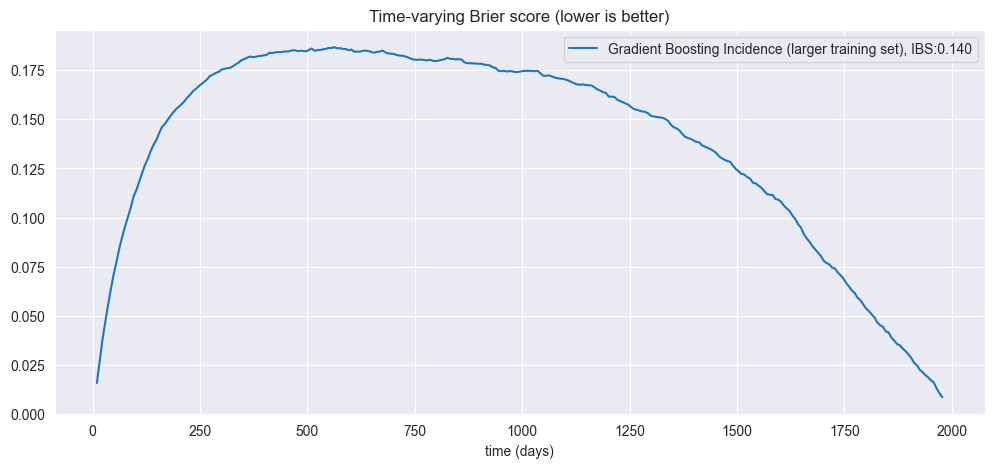

In [60]:
%%time

gb_incidence_large = make_pipeline(
    simple_preprocessor,
    GradientBoostingIncidence(max_leaf_nodes=31, learning_rate=0.1, n_iter=100),
)
gb_incidence_large.fit(X_train_large, y_train_large)
gb_incidence_large_survival_probas = gb_incidence_large.predict_survival_function(X_test, times=time_grid)

large_model_evaluator("Gradient Boosting Incidence (larger training set)", gb_incidence_large_survival_probas)

### Comparing our estimates to the theoretical survival curves

Since the dataset is synthetic, we can access the underlying hazard function for each row of `X_test` and select the test records:

In [61]:
theoretical_hazards = theoretical_hazards[idx_test]
theoretical_hazards.shape

(7320, 3650)

and finally, do a numerical integration over the last dimension (using `cumsum(axis=-1)`) and take the exponential of the negative cumulated hazards to recover the theoretical survival curves for each sample of the test set:

In [62]:
theoretical_survival_curves = np.exp(-theoretical_hazards.cumsum(axis=-1))
theoretical_survival_curves.shape

(7320, 3650)

Finally, we can evaluate the performance metrics (IBS and C-index) of the theoretical curves, on the same test events and `time_grid`, to estimate the discrepancy between our best predictive models and the optimal model:

In [63]:
time_grid.shape

(300,)

,Model,IBS,C-index
0,Constant linear,0.1854,0.5000
1,Kaplan-Meier,0.1739,0.5000
2,Cox PH,0.1460,0.6902
3,Polynomial Cox PH,0.1413,0.6966
4,Gradient Boosting Incidence,0.1407,0.6941
5,Data generating process,0.1384,0.6987


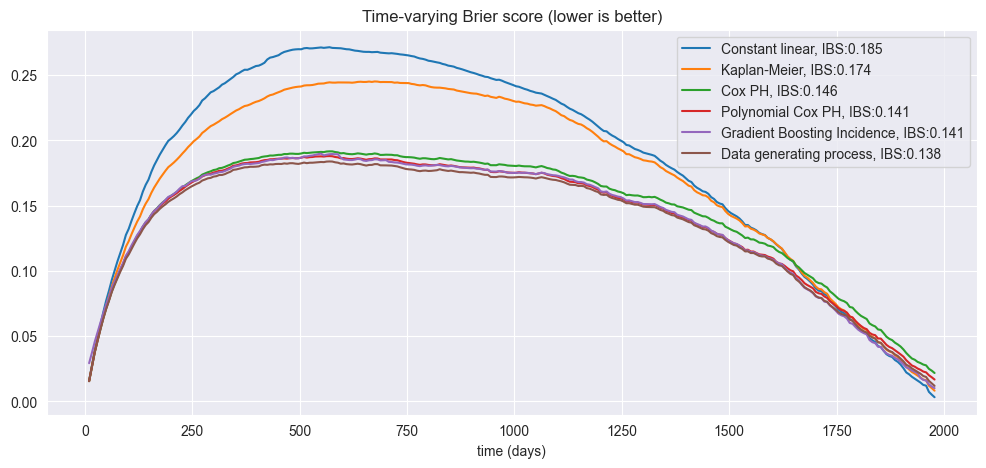

In [64]:
n_total_days = theoretical_hazards.shape[-1]
original_time_range = np.linspace(0, n_total_days, n_total_days)

theoretical_survival_curves = np.asarray([
    interp1d(
        original_time_range,
        surv_curve,
        kind="previous",
        bounds_error=False,
        fill_value="extrapolate",
    )(time_grid) for surv_curve in theoretical_survival_curves
])

evaluator("Data generating process", theoretical_survival_curves)

The fact that the C-index of the Polynomial Cox PH model can some times be larger than the C-index of the theoretical curves is quite unexpected and would deserve further investigation. It could be an artifact of our evaluation on a finite size test set and the use of partially censored test data.

Let's also compare with the version of the model trained on the large dataset:

,Model,IBS,C-index
0,Gradient Boosting Incidence (larger training set),0.1398,0.6954
1,Data generating process,0.1387,0.6987


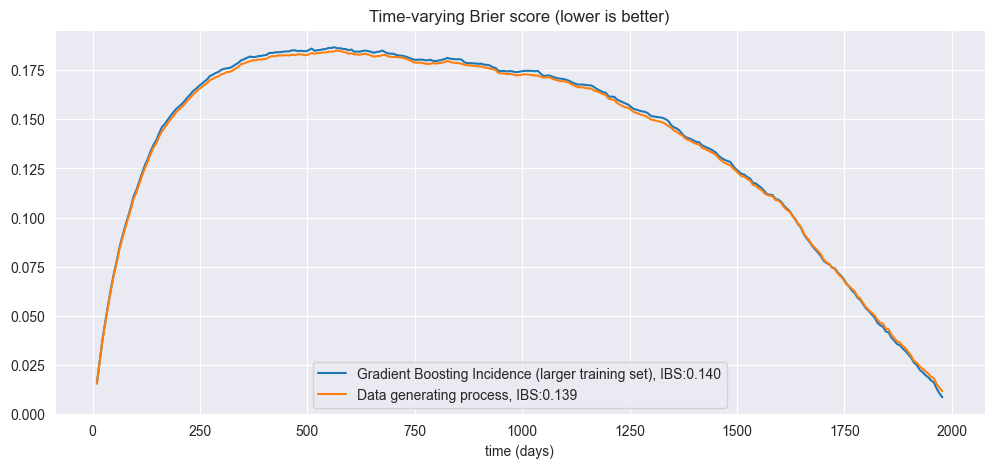

In [65]:
large_model_evaluator("Data generating process", theoretical_survival_curves)

We observe that our best models are quite close to the theoretical optimum but there is still some slight margin for improvement. It's possible that re-training the same model pipelines with even larger number of training data points or better choice of hyperparameters and feature preprocessing could help close that gap.

Note that the IBS and C-index values of the theoretical survival curves are far from 0.0 and 1.0 respectively: this is expected because not all the variations of the target `y` can be explained by the values of the columns of `X`: there is still a large irreducible amount of unpredictable variability (a.k.a. "noise") in this data generating process.

Since our estimators are conditional models, it's also interesting to compare the predicted survival curves for a few test samples and contrasting those to the
theoretical survival curves:

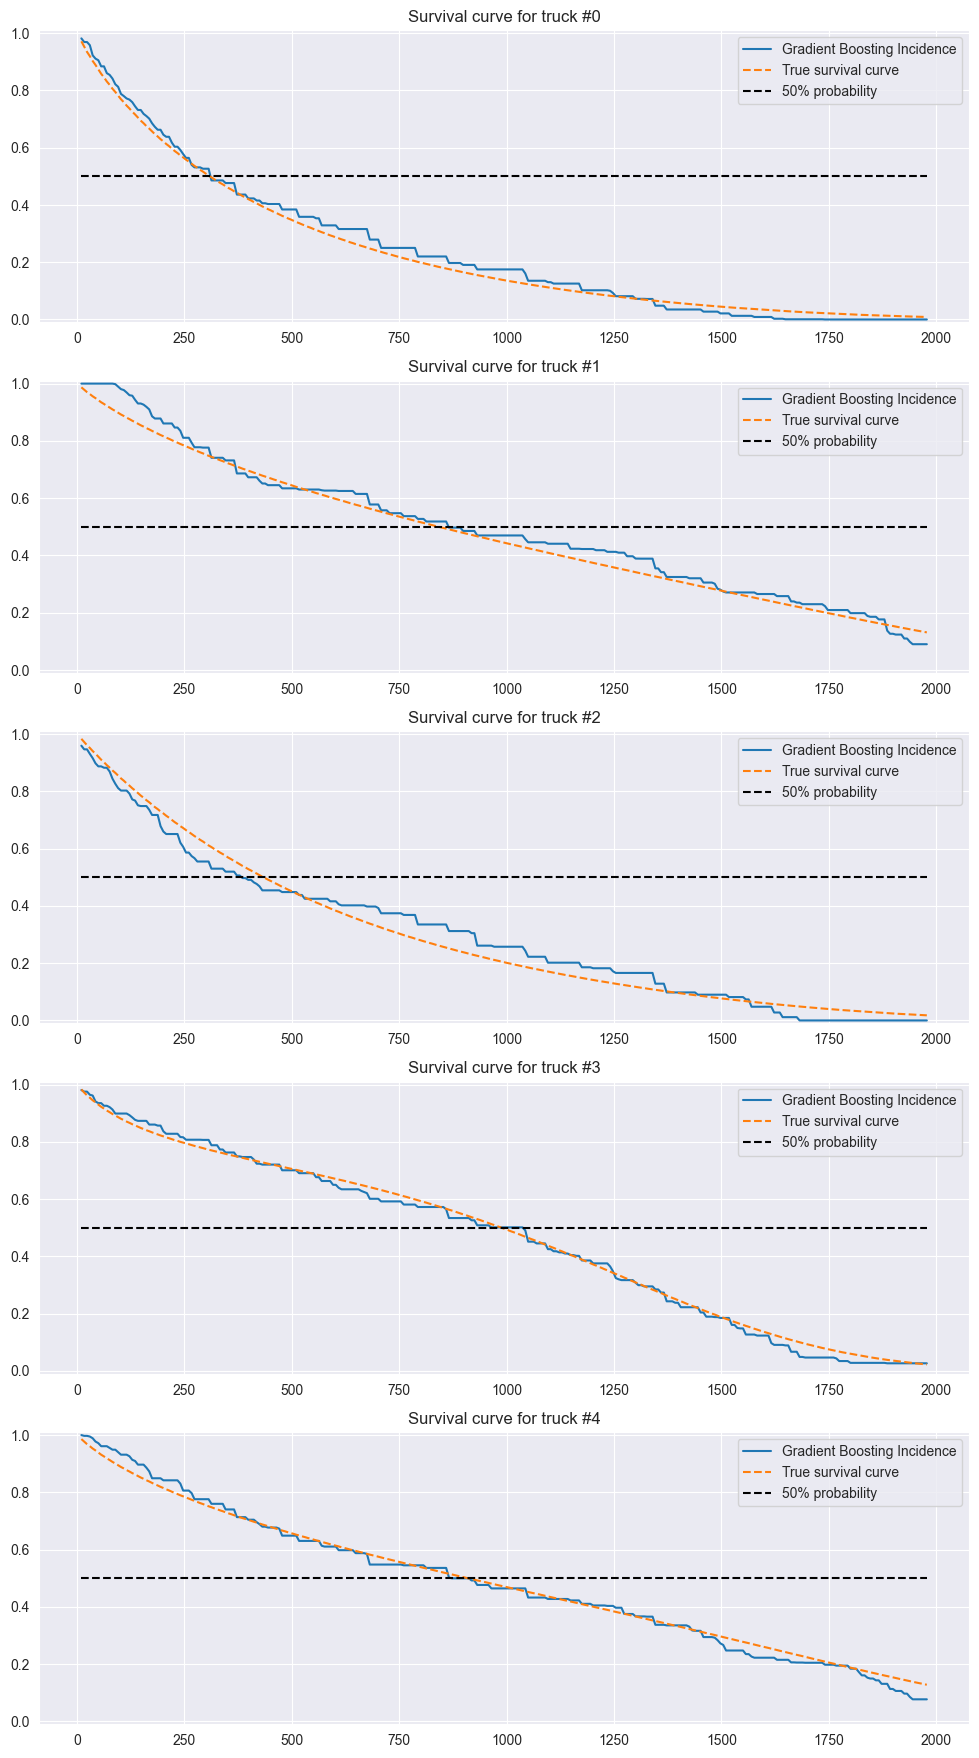

In [66]:
fig, axes = plt.subplots(nrows=5, figsize=(12, 22))

for sample_idx, ax in enumerate(axes):
    ax.plot(time_grid, gb_incidence_large_survival_probas[sample_idx], label="Gradient Boosting Incidence")
    if poly_cox_ph_large_survival_probas is not None:
        ax.plot(time_grid, poly_cox_ph_large_survival_probas[sample_idx], label="Polynomial Cox PH")
    ax.plot(time_grid, theoretical_survival_curves[sample_idx], linestyle="--", label="True survival curve")
    ax.plot(time_grid, 0.5 * np.ones_like(time_grid), linestyle="--", color="black", label="50% probability")
    ax.set(
        title=f"Survival curve for truck #{sample_idx}",
        ylim=[-.01, 1.01],
    )
    ax.legend()

The individual survival functions predicted by the polynomial Cox PH model are always smooth, but we can observe that they don't always match the true survival curve.

We can also observe that the individual survival curves of the Gradient Boosting Incidence model **suffer from the constant-piecewise prediction function of the underlying decision trees**. But despite this limitation, this model still yields very good approximation to the true survival curves. In particular **they can provide competitive estimates of the median survival time** for instance.

Let's check this final assertion by comparing the [Mean absolute error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) for the median survival time estimates for our various estimators. Note that we can only do this because our data is synthetic and we have access to the true median survival time derived from the data generating process.

In [67]:
from sklearn.metrics import mean_absolute_error


def quantile_survival_times(times, survival_curves, q=0.5):
    increasing_survival_curves = survival_curves[:, ::-1]
    median_indices = np.apply_along_axis(
        lambda a: a.searchsorted(q), axis=1, arr=increasing_survival_curves
    )
    return times[-median_indices]


def compute_quantile_metrics(evaluator):
    all_metrics = []
    for model_name, info in evaluator.model_data.items():
        survival_curves = info["survival_curves"]
        record = {"Model": model_name}
        for q in [0.25, 0.5, 0.75]:
            mae = mean_absolute_error(
                quantile_survival_times(time_grid, survival_curves, q=q),
                quantile_survival_times(time_grid, theoretical_survival_curves, q=q),
            )
            record[f"MAE for q={np.round(q, 2)}"] = mae.round(1)
        all_metrics.append(record)
    return pd.merge(evaluator.metrics_table(), pd.DataFrame(all_metrics))


compute_quantile_metrics(evaluator)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Constant linear,0.1854,0.5000,487.9,438.6,305.3
1,Kaplan-Meier,0.1739,0.5000,473.9,433.8,280.5
2,Cox PH,0.1460,0.6902,386.3,160.5,119.8
3,Polynomial Cox PH,0.1413,0.6966,189.6,117.5,103.4
4,Gradient Boosting Incidence,0.1407,0.6941,173.7,103.1,80.2
5,Data generating process,0.1384,0.6987,0.0,0.0,0.0


In [68]:
compute_quantile_metrics(large_model_evaluator)

,Model,IBS,C-index,MAE for q=0.25,MAE for q=0.5,MAE for q=0.75
0,Gradient Boosting Incidence (larger training set),0.1398,0.6954,95.4,50.3,39.7
1,Data generating process,0.1387,0.6987,0.0,0.0,0.0


This confirms that the best estimators ranked by IBS computed on a censored test sample are the most accurately modeling the uncensored time-to-event distribution.

Furthermore, we observe that a small gain in IBS can have a significant impact in terms of MAE and Gradient Boosting Incidence can reduce its prediction error significantly by increasing the size of the training set and simultaneously increasing the number of leaf nodes per tree.

This is not the case of the Polynomial Cox PH model which seems to be intrisically limited by its core modeling assumption: the shape of the Cox PH hazard function depends on $t$ but is independent of $X$. If this assumption does not hold, no amount of additional training data will help the estimator reach the optimal IBS.

## Going further

We encourage you to dive deeper in the documentation of the [lifelines](https://lifelines.readthedocs.io) and [scikit-survival](https://scikit-survival.readthedocs.io/) packages.

You might be interested in the following notable alternatives not presented in this notebook:

- XGBoost has a builtin handling of [survival analysis with censored data](https://xgboost.readthedocs.io/en/stable/tutorials/aft_survival_analysis.html). However it does only provide predictions at fixed time horizons and does not attempt to estimate the full survival function.
- [XGBoost Survival Embeddings](https://loft-br.github.io/xgboost-survival-embeddings/index.html): another way to leverage gradient boosting for survival analysis.
- [DeepHit](https://github.com/chl8856/DeepHit): neural network based, typically with good ranking power but not necessarily well calibrated. Can also handle competing risks.
- [SurvTRACE](https://github.com/RyanWangZf/SurvTRACE): more recent transformer-based model. Can also handle competing risks, with SOTA performances in cause-specific IBS and Ctd-index. See our [benchmark poster](https://www.dropbox.com/scl/fi/mi8ehqprymcpc91ex7tfl/euroscipy2023_hazardous.pdf?rlkey=wsh0bspdi1qqya8p2aliuq08a&dl=0).